In [2]:
from fktools import *

import tensorflow as tf

from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import CDKMRippleCarryAdder, ModularAdderGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeVigoV2, FakeTorino

import networkx as nx

import math

from tqdm import tqdm

2025-12-29 15:50:00.227593: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-29 15:50:00.262340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-29 15:50:01.026092: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/filip/miniconda3/envs/defects/lib/python3.11/site-packages/keras/src/export/tf2onnx_l

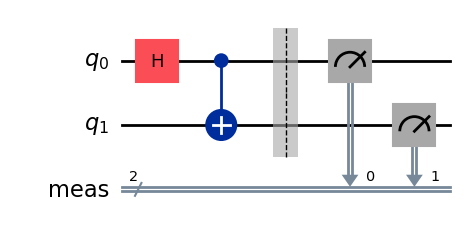

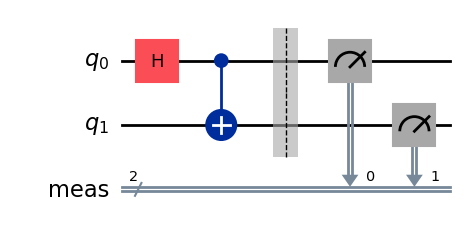

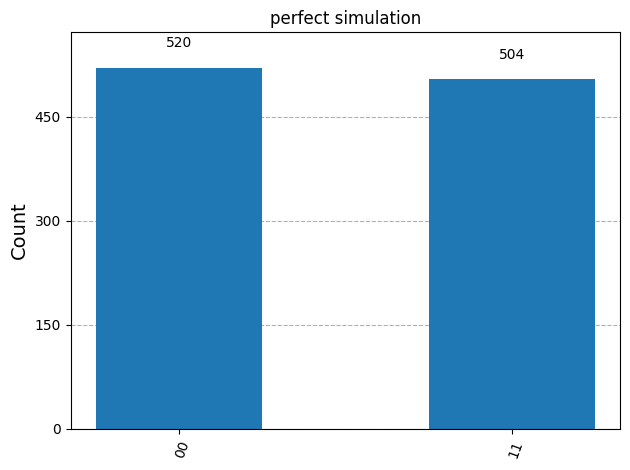

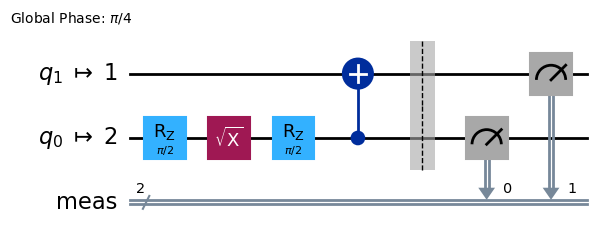

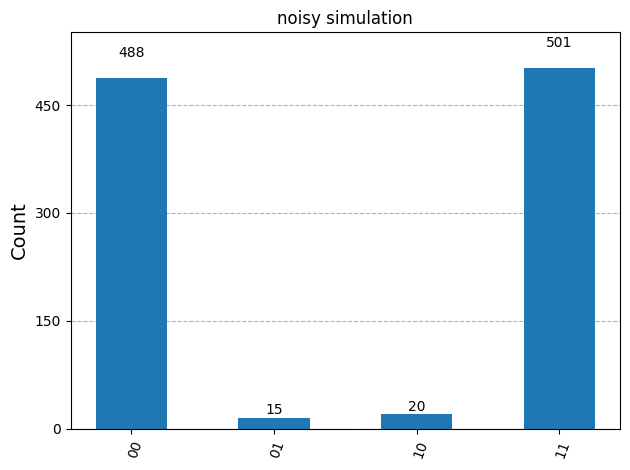

In [2]:
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

display(circ.draw('mpl'))


sim_ideal = AerSimulator()

tcirc = transpile(circ, sim_ideal)

result = sim_ideal.run(tcirc).result()
counts = result.get_counts(0)

display(tcirc.draw('mpl'))
display(plot_histogram(counts, title="perfect simulation"))



device_backend = FakeVigoV2()
sim_vigo = AerSimulator.from_backend(device_backend)

tcirc = transpile(circ, sim_vigo)

result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)

display(tcirc.draw('mpl'))
display(plot_histogram(counts_noise, title="noisy simulation"))


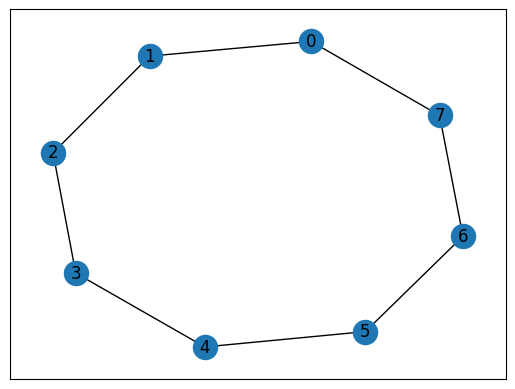

In [3]:
nodes = 2**3

G = nx.Graph()

G.add_nodes_from(np.arange(nodes).tolist())
G.add_edges_from([(i, (i+1)%nodes) for i in range(nodes)])
nx.draw_networkx(G)

In [91]:
class walk_circuit:
    def __init__(self, nodes_power, num_steps):
        self.nodes_power = nodes_power
        self.num_steps = num_steps

    def build(self) -> QuantumCircuit:
        q_pos = QuantumRegister(self.nodes_power, "q_pos")
        q_one = QuantumRegister(self.nodes_power, "q_one")  
        q_coin = QuantumRegister(1, "q_coin") 
        c_pos = ClassicalRegister(self.nodes_power, "c_pos")
        regs = [q_one, q_pos, q_coin, c_pos]


        ControlledModularAdder = ModularAdderGate(num_state_qubits=self.nodes_power).control(num_ctrl_qubits=1)

        qc = QuantumCircuit(*regs)

        qc.x(q_one[0])


        for _ in range(self.num_steps):

            qc.h(q_coin)

            qc.append(ControlledModularAdder, [q_coin, *q_one, *q_pos])

            qc.x(q_coin)
            qc.append(ControlledModularAdder.inverse(), [q_coin, *q_one, *q_pos])
            qc.x(q_coin)


        qc.measure(q_pos, c_pos)

        self.qc = qc

        return qc
    
    def run(self, simulator = AerSimulator(), shots = 1024):

        tcirc = transpile(self.qc, simulator)

        result = simulator.run(tcirc, shots=shots).result()
        counts = result.get_counts(0)

        probs = np.zeros(shape=(2**self.nodes_power), dtype=np.float32)

        for key in counts.keys():
            probs[int(key, 2)] = counts[key]
        probs /= np.sum(probs)

        return probs

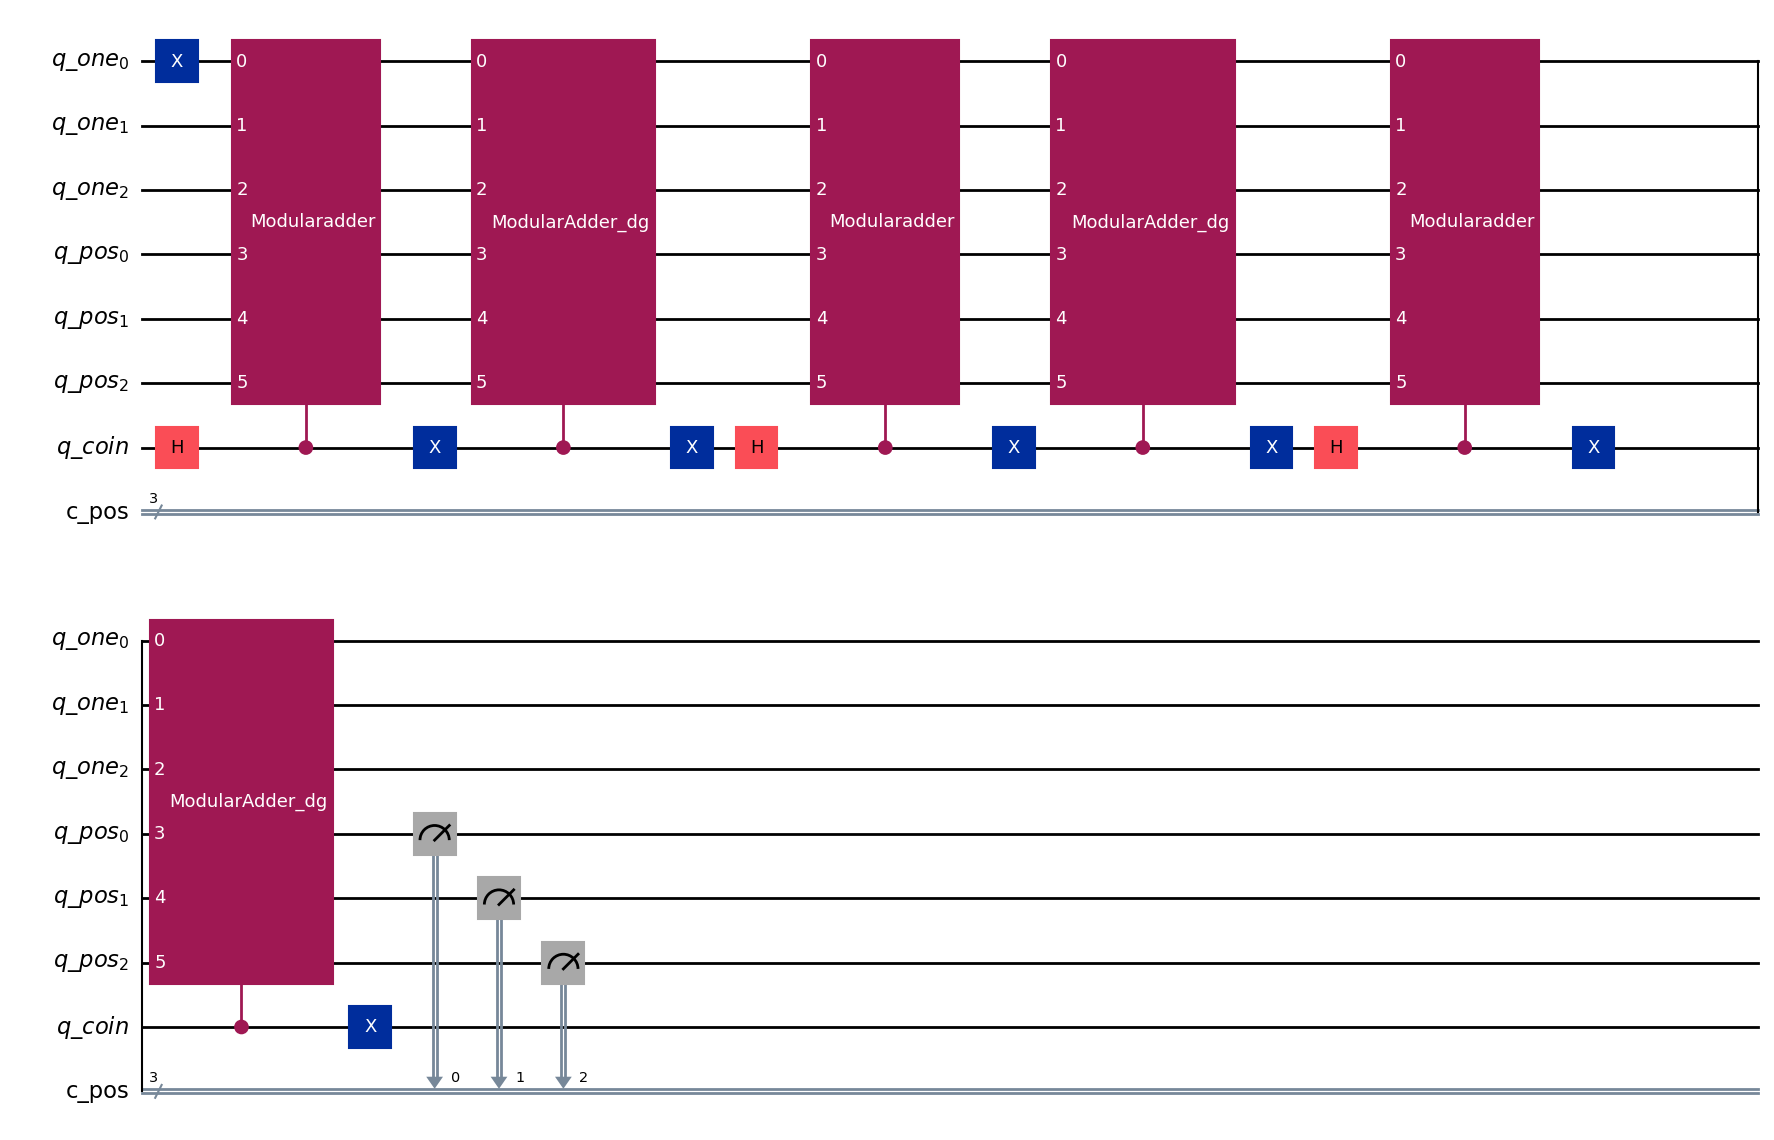

15


In [5]:
wc = walk_circuit(3, 3)
qc = wc.build()
display(qc.draw('mpl'))
print(qc.depth())

<BarContainer object of 8 artists>

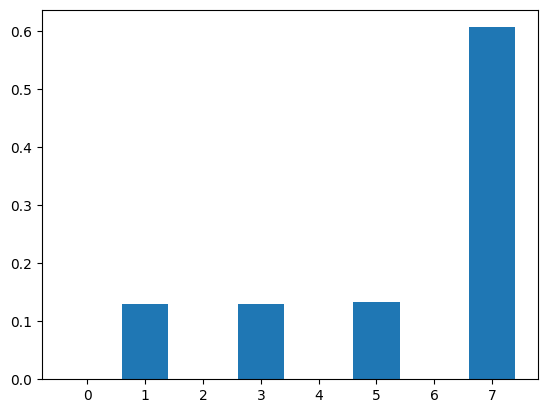

In [6]:
plt.bar(np.arange(2**wc.nodes_power), wc.run())

<BarContainer object of 8 artists>

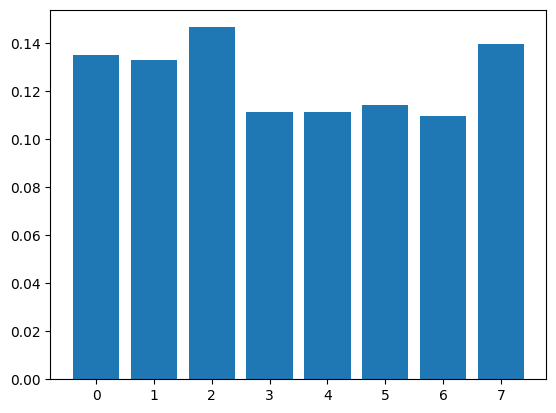

In [7]:
plt.bar(np.arange(2**wc.nodes_power), wc.run(simulator=FakeTorino()))

In [8]:
steps = 4
power = 3
propagation = np.zeros(shape=(steps, 2**power))

for step in range(steps):
    wc = walk_circuit(power, step)
    qc = wc.build()
    propagation[step] = wc.run(simulator=FakeTorino())

plt.imshow(propagation, cmap='turbo')

KeyboardInterrupt: 

In [ ]:
class walk_circuit_times3:
    def __init__(self, nodes_power, num_steps):
        self.nodes_power = nodes_power
        self.num_steps = num_steps

    def build(self) -> QuantumCircuit:
        q_pos1 = QuantumRegister(self.nodes_power, "q_pos1")
        q_pos2 = QuantumRegister(self.nodes_power, "q_pos2")
        q_pos3 = QuantumRegister(self.nodes_power, "q_pos3")
        q_one1 = QuantumRegister(self.nodes_power, "q_one1")
        q_one2 = QuantumRegister(self.nodes_power, "q_one2")
        q_one3 = QuantumRegister(self.nodes_power, "q_one3")
        q_coin = QuantumRegister(1, "q_coin")
        q_res = QuantumRegister(self.nodes_power, "q_res")
        c_pos = ClassicalRegister(self.nodes_power, "c_pos1")
        regs = [q_one1,q_pos1, q_one2,q_pos2 ,q_one3,q_pos3, q_coin, q_res, c_pos]


        ControlledModularAdder = ModularAdderGate(num_state_qubits=self.nodes_power).control(num_ctrl_qubits=1)

        qc = QuantumCircuit(*regs)

        qc.x(q_one1[0])
        qc.x(q_one2[0])
        qc.x(q_one3[0])


        for _ in range(self.num_steps):

            qc.h(q_coin)

            qc.append(ControlledModularAdder, [q_coin, *q_one1, *q_pos1])
            qc.append(ControlledModularAdder, [q_coin, *q_one2, *q_pos2])
            qc.append(ControlledModularAdder, [q_coin, *q_one3, *q_pos3])

            qc.x(q_coin)
            qc.append(ControlledModularAdder.inverse(), [q_coin, *q_one1, *q_pos1])
            qc.append(ControlledModularAdder.inverse(), [q_coin, *q_one2, *q_pos2])
            qc.append(ControlledModularAdder.inverse(), [q_coin, *q_one3, *q_pos3])
            qc.x(q_coin)


        for i in range(self.nodes_power):
            qc.mcx([q_pos1[i], q_pos2[i]], q_res[i])
            qc.mcx([q_pos2[i], q_pos3[i]], q_res[i])
            qc.mcx([q_pos1[i], q_pos3[i]], q_res[i])

        qc.measure(q_res, c_pos)

        self.qc = qc

        return qc
    
    def run(self, simulator = AerSimulator(), shots = 1024):

        tcirc = transpile(self.qc, simulator)

        result = simulator.run(tcirc, shots=shots).result()
        counts = result.get_counts(0)

        probs = np.zeros(shape=(2**self.nodes_power), dtype=np.float32)

        for key in counts.keys():
            probs[int(key, 2)] = counts[key]
        probs /= np.sum(probs)

        return probs

In [20]:
# wct = walk_circuit_test(2, 1)
# qct = wct.build()

wc = walk_circuit(2, 2)
qc = wc.build()

# display(qct.draw('mpl'))
# print(qct.depth())

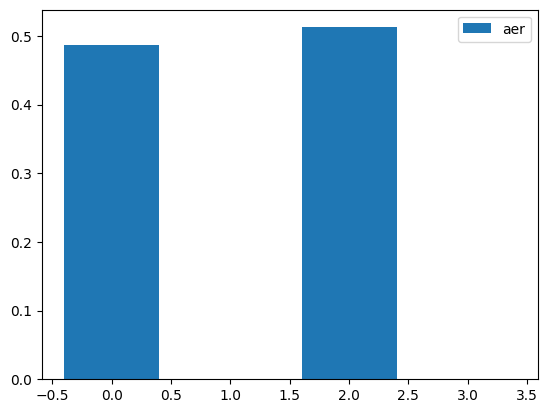

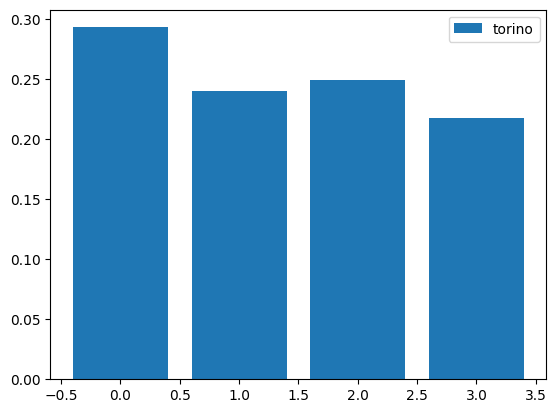

In [21]:
plt.bar(np.arange(2**wc.nodes_power), wc.run(simulator=AerSimulator()), label="aer")
plt.legend()
plt.show()
plt.bar(np.arange(2**wc.nodes_power), wc.run(simulator=FakeTorino()), label="torino")
plt.legend()
plt.show()

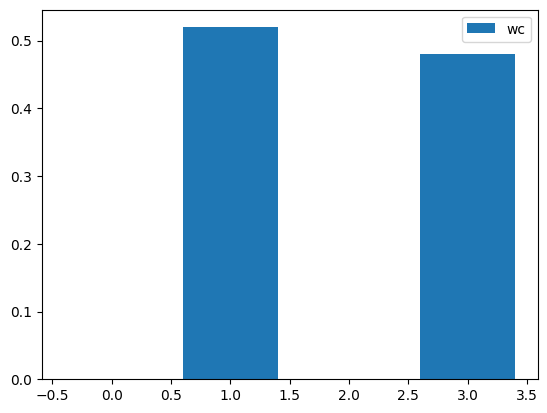

In [16]:
plt.bar(np.arange(2**wc.nodes_power), wc.run(), label="wc")
plt.legend()
plt.show()

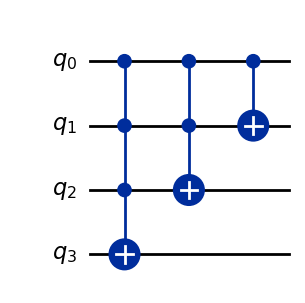

96

In [42]:
at3 = QuantumCircuit(4)

at3.mcx([0, 1, 2], 3)
at3.mcx([0, 1], 2)
at3.mcx([0], 1)

display(at3.draw('mpl'))


qc.measure_all()




simulator = AerSimulator()
tqc = transpile(qc, simulator)




result = simulator.run(tqc).result()
counts = result.get_counts(0)
plot_histogram(counts)
tqc.depth()

In [4]:
def control_add_one(position_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(position_qubits + 1, name='control_add_one')

    for i in range(position_qubits, 0, -1):
        qc.mcx([j for j in range(i)], i)
    
    return qc

class walk_circuit_simpler:
    def __init__(self, nodes_power, num_steps, use_phase_defect=False, defect_step=None, defect_qubit=None, defect_strength=None):
        self.nodes_power = nodes_power
        self.num_steps = num_steps
        self.use_phase_defect = use_phase_defect
        self.defect_step = defect_step
        self.defect_qubit = defect_qubit
        self.defect_strength = defect_strength

    def build(self) -> QuantumCircuit:
        q_pos = QuantumRegister(self.nodes_power, "q_pos")
        q_coin = QuantumRegister(1, "q_coin")
        c_pos = ClassicalRegister(self.nodes_power, "c_pos")
        regs = [q_pos, q_coin, c_pos]

        qc = QuantumCircuit(*regs)

        qc.x(q_pos[-1])

        for step in range(self.num_steps):
            # coin
            qc.h(q_coin)


            # defect
            if self.use_phase_defect and self.defect_step is not None and self.defect_qubit is not None and self.defect_strength is not None:
                if step == self.defect_step:
                    qc.p(self.defect_strength, self.defect_qubit)


            # shift right for coin |1>
            qc.append(control_add_one(self.nodes_power), [q_coin, *q_pos])
            
            # shift left for coin |0>
            qc.x(q_coin)
            qc.x(q_pos)
            qc.append(control_add_one(self.nodes_power), [q_coin, *q_pos])
            qc.x(q_coin)
            qc.x(q_pos)


        qc.measure(q_pos, c_pos)

        self.qc = qc

        return qc
    
    def run(self, simulator = AerSimulator(), shots = 1024):

        tcirc = transpile(self.qc, simulator)

        result = simulator.run(tcirc, shots=shots).result()
        counts = result.get_counts(0)

        probs = np.zeros(shape=(2**self.nodes_power), dtype=np.float32)

        for key in counts.keys():
            probs[int(key, 2)] = counts[key]
        probs /= np.sum(probs)

        return probs

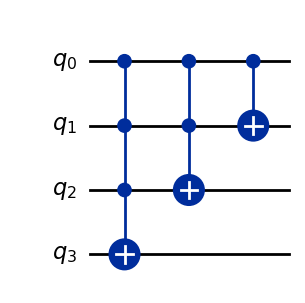

In [81]:
control_add_one(3).draw('mpl')

1 3 63
2 59 1384
3 191 2485
4 657 3616
5 1439 4914
6 2539 6262
7 3928 7471
8 5819 8449
9 8174 9948
10 10466 11180
11 13463 12278
12 17608 13629
13 20820 14678
14 25345 16006
15 29821 17209
16 35024 18564
17 40332 19800
18 45580 21236
19 50674 22457


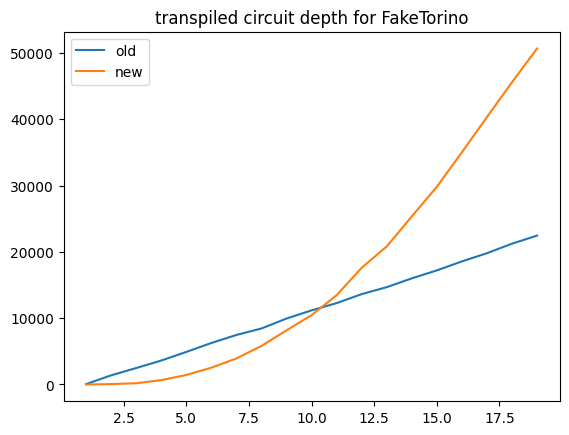

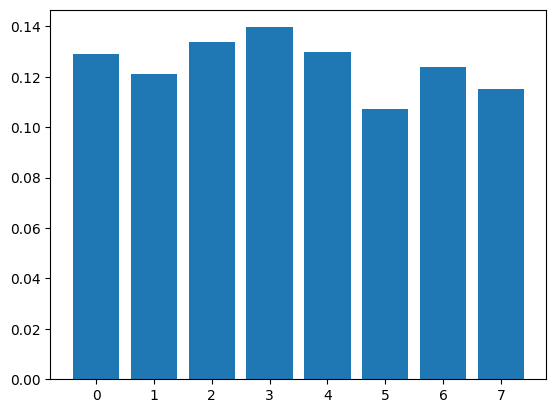

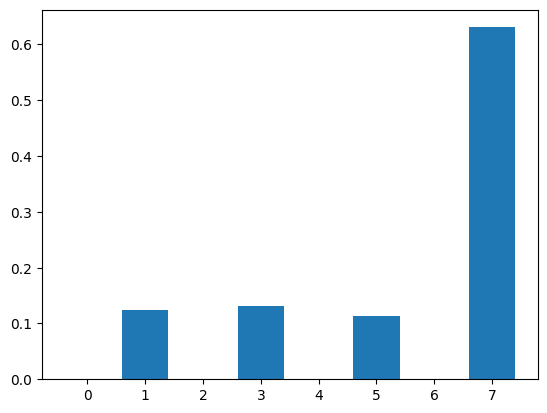

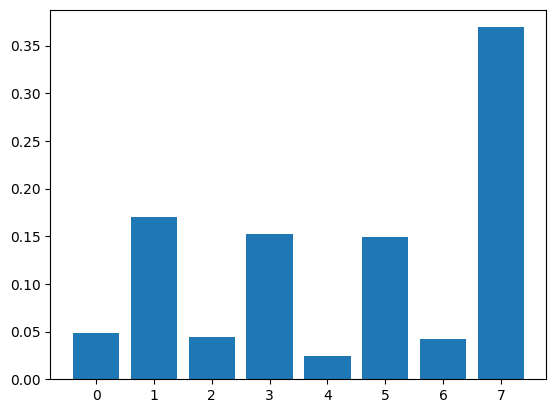

In [102]:
wcd = []
wcsd = []

for i in range(1, 20):
    wc = walk_circuit(i, 1)
    wcs = walk_circuit_simpler(i, 1)

    qc = wc.build()
    qc = transpile(qc, FakeTorino())

    qcs = wcs.build()
    qcs = transpile(qcs, FakeTorino())


    print(i, qcs.depth(), qc.depth())
    wcd.append(qc.depth())
    wcsd.append(qcs.depth())


plt.plot(np.arange(1, len(wcd)+1), wcd, label="old")
plt.plot(np.arange(1, len(wcsd)+1), wcsd, label="new")
plt.legend()
plt.title("transpiled circuit depth for FakeTorino")
plt.show()



wc = walk_circuit(3, 3)
wcs = walk_circuit_simpler(3, 3)

qc = wc.build()
qc = transpile(qc, FakeTorino())

qcs = wcs.build()
qcs = transpile(qcs, FakeTorino())
plt.bar(np.arange(2**wc.nodes_power), wc.run(simulator=FakeTorino()), label="wc")
plt.show()
plt.bar(np.arange(2**wcs.nodes_power), wcs.run(simulator=AerSimulator()), label="wcs")
plt.show()
plt.bar(np.arange(2**wcs.nodes_power), wcs.run(simulator=FakeTorino()), label="wcs")
plt.show()


100%|██████████| 48/48 [00:06<00:00,  7.26it/s]


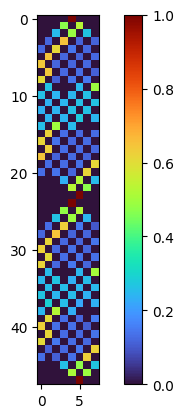

<BarContainer object of 8 artists>

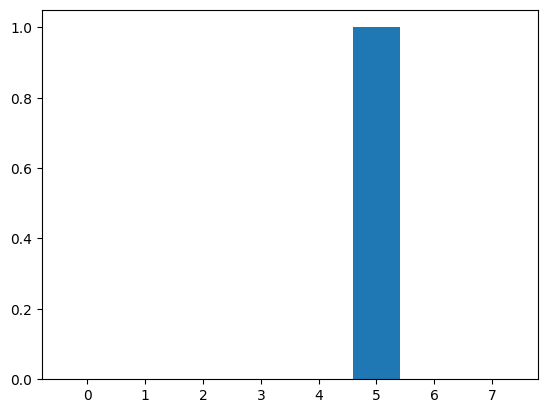

In [ ]:
from walk import walk_circuit_simpler

walk_steps = 48
power_steps = 3
simulator = AerSimulator()

propagation = np.zeros(shape=(walk_steps, 2**power_steps), dtype=np.float32)

for i in tqdm(range(walk_steps)):
    wcs = walk_circuit_simpler(power_steps, i)
    qcs = wcs.build()
    qcs = transpile(qcs, simulator)

    propagation[i] = wcs.run(simulator=simulator)

plt.imshow(propagation, cmap='turbo')
plt.colorbar()
plt.show()

plt.bar(np.arange(2**power_steps), propagation[-1])

100%|██████████| 32/32 [01:21<00:00,  2.54s/it]


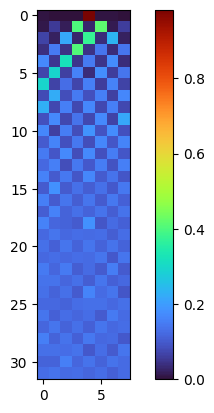

<BarContainer object of 8 artists>

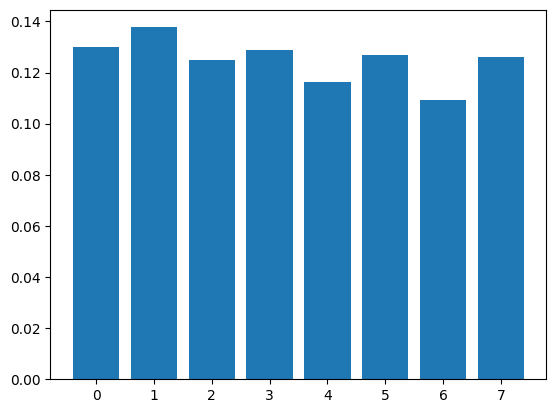

In [15]:
walk_steps = 32
power_steps = 3
simulator = FakeTorino()

propagationTorino = np.zeros(shape=(walk_steps, 2**power_steps), dtype=np.float32)

for i in tqdm(range(walk_steps)):
    wcs = walk_circuit_simpler(power_steps, i)
    qcs = wcs.build()
    qcs = transpile(qcs, simulator)

    propagationTorino[i] = wcs.run(simulator=simulator)

plt.imshow(propagationTorino, cmap='turbo')
plt.colorbar()
plt.show()

plt.bar(np.arange(2**power_steps), propagationTorino[-1])

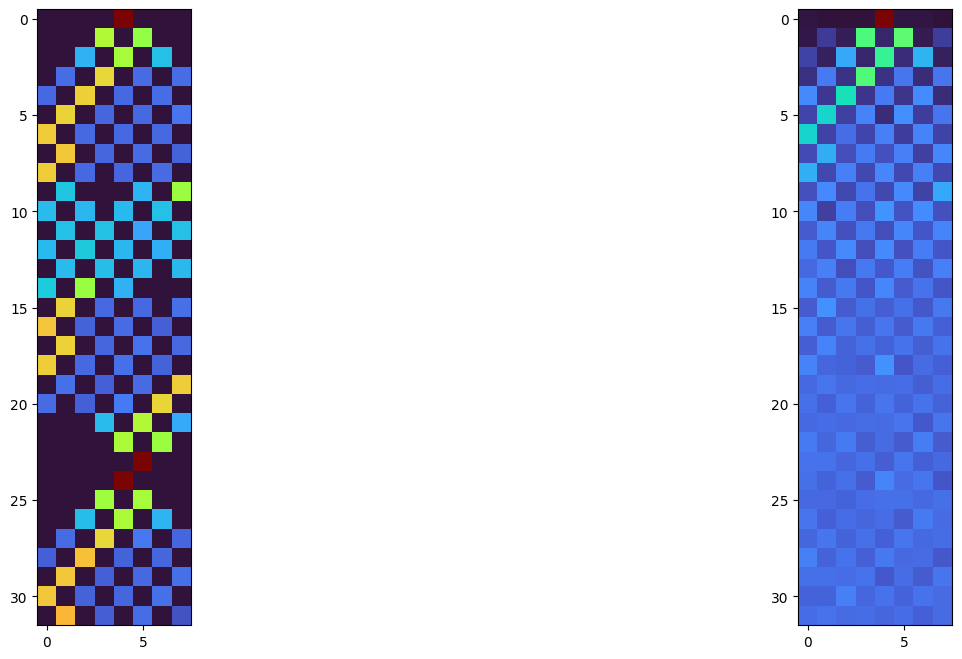

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(18,8))

ax[0].imshow(propagation, cmap='turbo')
ax[1].imshow(propagationTorino, cmap='turbo')

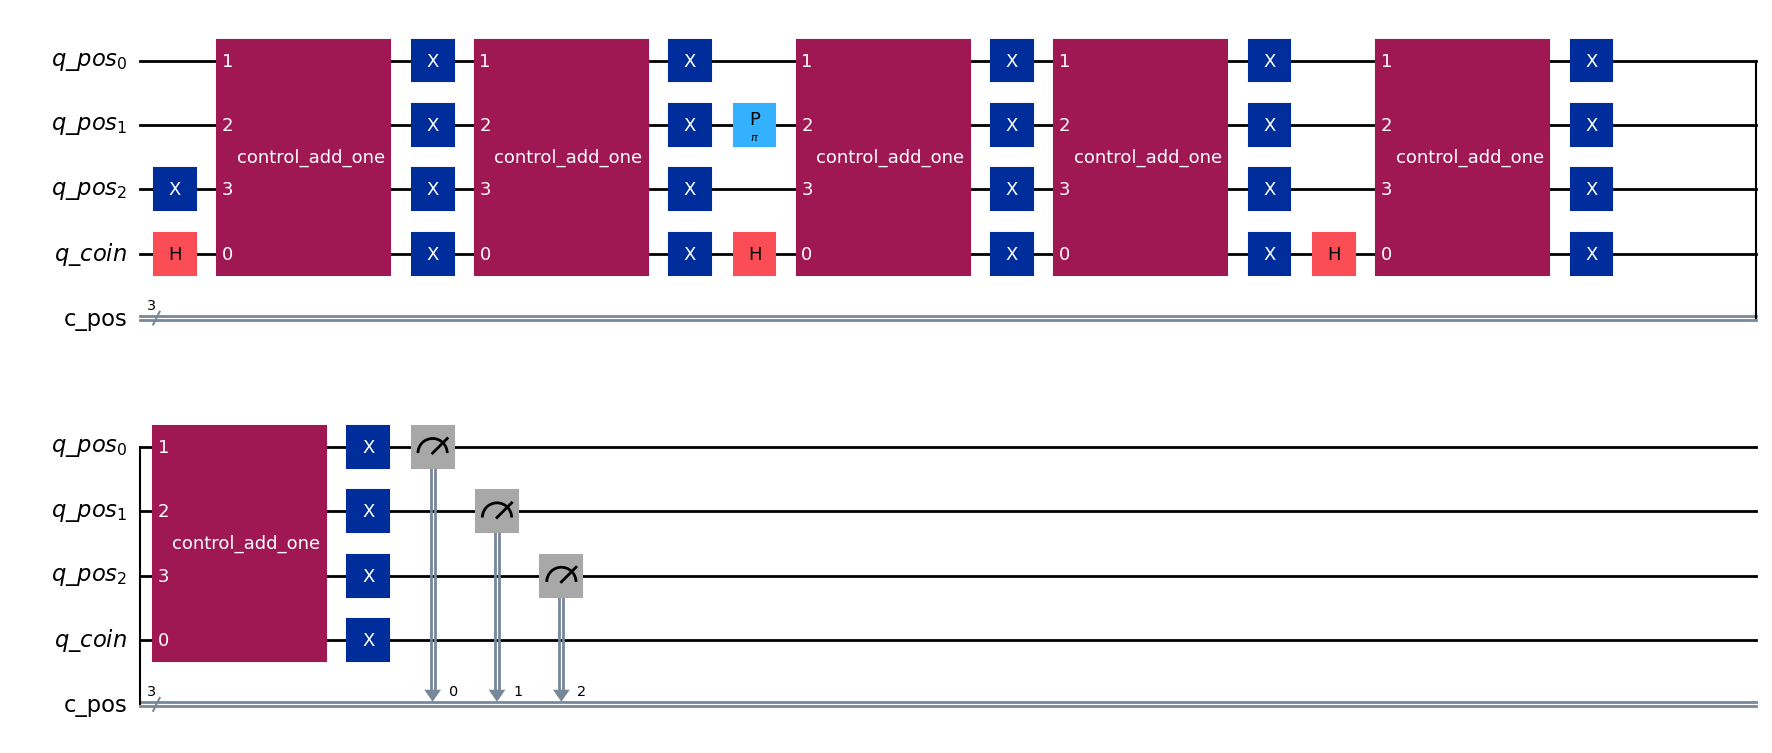

In [38]:
wcs = walk_circuit_simpler(3, 3, True, 1, 1, np.pi)
qcs = wcs.build()
display(qcs.draw('mpl'))